# Customer Revenue Prediction EDA

##### Yuji Mori
##### Last Updated: 02/02/2021
##### STATS 404 WQ2021

In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt 
import seaborn as sns 

--------
### Step 1. Import Data and Flatten JSON columns

**NOTE: MY DATA IS ALREADY SPLIT INTO TRAINING/TESTING (train_v2.csv, test_v2.csv)**

I am working with a CSV, but the nested JSON columns were originally a set of BigQuery tables. The data dictionary for these tables is here:

https://support.google.com/analytics/answer/3437719?hl=en

For now I am only importing 100k columns because my training dataset is 25gb total

In [2]:
# JSON flattening code
# This code was widely used by most Kaggle competitiors due to JSON structure of some fields
# credit goes to:
# https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields

def load_df(csv_path='../data/test.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [3]:
train_df = load_df(csv_path='../data/train_v2.csv', nrows=100000)

<ipython-input-2-382b1299a998>:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  column_as_df = json_normalize(df[column])


Loaded train_v2.csv. Shape: (100000, 59)


In [4]:
train_df.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,...,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,...,water bottle,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,...,NaN,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Chrome,...,NaN,not available in demo dataset,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,1508169851,1,1508169851,Chrome,...,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,1508190552,1,1508190552,Chrome,...,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
train_df.columns

Index(['channelGrouping', 'customDimensions', 'date', 'fullVisitorId', 'hits',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserVersion', 'device.browserSize',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.isMobile', 'device.mobileDeviceBranding',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.flashVersion', 'device.language', 'device.screenColors',
       'device.screenResolution', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.networkDomain', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits',
 

--------

### Step 2: Remove uninformative columns

In [6]:
# identify columns with missing values
missing_check = train_df.isnull().sum().sort_values(ascending = False) 
missing_check[~(missing_check == 0)]

# despite some poor fill rates, we found that there are no columns that are 100% missing.

totals.totalTransactionRevenue                  99003
totals.transactionRevenue                       99003
totals.transactions                             98998
trafficSource.adContent                         96237
trafficSource.adwordsClickInfo.isVideoAd        95609
trafficSource.adwordsClickInfo.slot             95609
trafficSource.adwordsClickInfo.page             95609
trafficSource.adwordsClickInfo.adNetworkType    95609
trafficSource.adwordsClickInfo.gclId            95571
trafficSource.isTrueDirect                      69538
trafficSource.keyword                           69218
trafficSource.referralPath                      65843
totals.sessionQualityDim                        53872
totals.bounces                                  50146
totals.timeOnSite                               49974
totals.newVisits                                23635
totals.pageviews                                   11
dtype: int64

Many of these columns may be dropped later, but I will check them out in the EDA for now.

Next, I want to identify and drop columns that are always the same value:

In [7]:
# dropping columns that are always the same value
nunique_cols = [col for col in train_df.columns if train_df[col].nunique() == 1]
train_df.drop(nunique_cols, axis=1,inplace=True)

In [8]:
# I AM REMOVING THE ENTIRE 'hits' COLUMN (for now)
# it has detailed metadata, but it may be beyond the scope of this project
train_df.drop(['customDimensions','hits'], axis=1,inplace=True)

In [9]:
# final column list:
print(train_df.shape)
train_df.columns

(100000, 34)


Index(['channelGrouping', 'date', 'fullVisitorId', 'visitId', 'visitNumber',
       'visitStartTime', 'device.browser', 'device.operatingSystem',
       'device.isMobile', 'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain',
       'totals.hits', 'totals.pageviews', 'totals.sessionQualityDim',
       'totals.timeOnSite', 'totals.transactions', 'totals.transactionRevenue',
       'totals.totalTransactionRevenue', 'trafficSource.campaign',
       'trafficSource.source', 'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.referralPath', 'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.adNetworkType'],
      dtype='object')

----------
### Step 3: Exploring the Target Variable

In [10]:
# FIRST, CONVERT TO NUMERIC:
train_df['totals.totalTransactionRevenue'] = pd.to_numeric(train_df['totals.totalTransactionRevenue'])

train_df['totals.totalTransactionRevenue'].describe().apply(lambda x: format(x, 'f'))

count           997.000000
mean      136845717.151454
std       302446564.429077
min         3400000.000000
25%        27990000.000000
50%        53570000.000000
75%       114650000.000000
max      5501000000.000000
Name: totals.totalTransactionRevenue, dtype: object

In [11]:
(train_df['totals.totalTransactionRevenue'].isnull()).sum()

99003

In [12]:
(train_df['totals.totalTransactionRevenue'].notnull()).sum()

997

In [13]:
((train_df['totals.totalTransactionRevenue'].notnull()).sum() / train_df.shape[0])*100

0.997

we see that the training dataset is highly unbalanced, below 1% fill rate. 

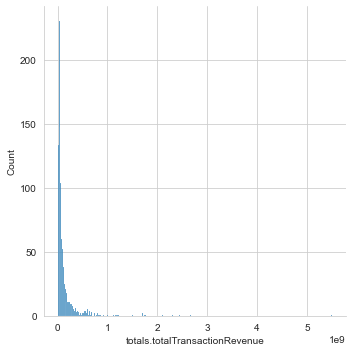

In [14]:
revenue_array = train_df['totals.totalTransactionRevenue']
revenue_array = revenue_array[~np.isnan(revenue_array)]
sns.set_style('whitegrid')
sns.displot(revenue_array)

<AxesSubplot:xlabel='totals.totalTransactionRevenue', ylabel='Density'>

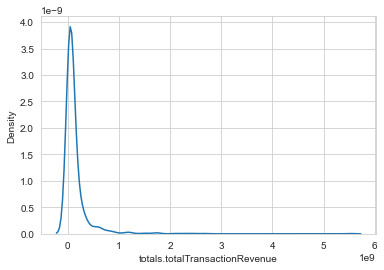

In [15]:
sns.kdeplot(revenue_array)

The original Kaggle competition asked for log transformed Revenue:

<AxesSubplot:xlabel='totals.totalTransactionRevenue', ylabel='Density'>

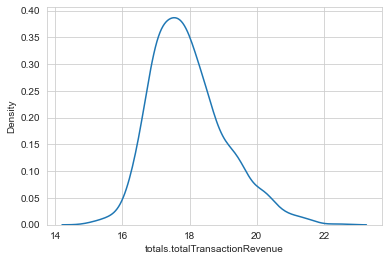

In [16]:
sns.kdeplot(np.log(revenue_array))

----------
### Step 4: Exploring the Predictor Variables

In [17]:
train_df.nunique().sort_values()

trafficSource.adwordsClickInfo.adNetworkType        2
device.isMobile                                     2
trafficSource.adwordsClickInfo.slot                 3
device.deviceCategory                               3
totals.transactions                                 5
trafficSource.adwordsClickInfo.page                 6
geoNetwork.continent                                6
trafficSource.medium                                7
channelGrouping                                     8
device.operatingSystem                             18
geoNetwork.subContinent                            23
trafficSource.campaign                             27
device.browser                                     35
date                                               38
trafficSource.adContent                            54
geoNetwork.metro                                   54
totals.sessionQualityDim                           96
totals.pageviews                                  115
trafficSource.source        

From the table of unique value counts above, we can deduce which columns can be treted as **categorical**. 



In [18]:
train_df['trafficSource.adwordsClickInfo.adNetworkType'].value_counts()

Content          2357
Google Search    2034
Name: trafficSource.adwordsClickInfo.adNetworkType, dtype: int64

In [19]:
train_df['trafficSource.adwordsClickInfo.slot'].value_counts()

RHS                       2371
Top                       1996
Google Display Network      24
Name: trafficSource.adwordsClickInfo.slot, dtype: int64

In [20]:
train_df['device.isMobile'].value_counts()

False    68926
True     31074
Name: device.isMobile, dtype: int64

... and so on.

Below I have made a few histograms for specific variables of interest:

-----

`ChannelGrouping`

_The Default Channel Group associated with an end user's session for this View._

<AxesSubplot:xlabel='channelGrouping', ylabel='Count'>

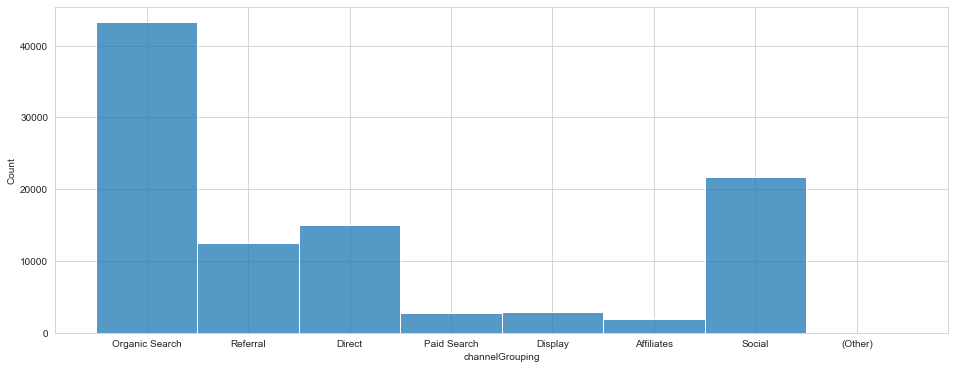

In [21]:
plt.figure(figsize=(16, 6))
sns.histplot(train_df['channelGrouping'])

<AxesSubplot:xlabel='channelGrouping', ylabel='totals.totalTransactionRevenue'>

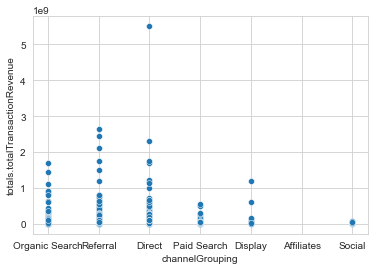

In [22]:
sns.scatterplot(x=train_df['channelGrouping'],y=train_df['totals.totalTransactionRevenue'])

`geoNetwork.continent` 

_The continent from which sessions originated, based on IP address._

<AxesSubplot:xlabel='geoNetwork.continent', ylabel='Count'>

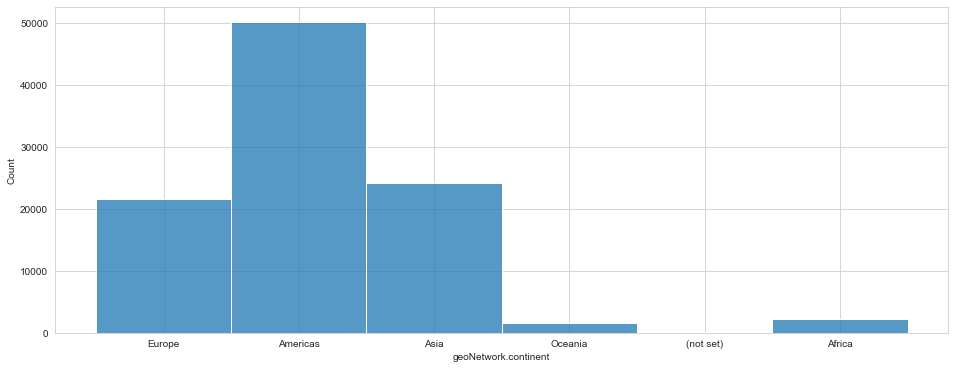

In [23]:
plt.figure(figsize=(16, 6))
sns.histplot(train_df['geoNetwork.continent'])

<AxesSubplot:xlabel='geoNetwork.continent', ylabel='totals.totalTransactionRevenue'>

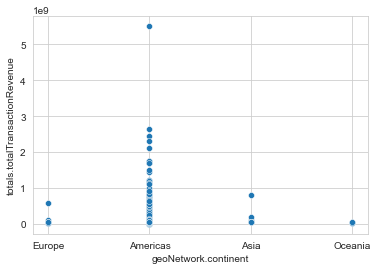

In [24]:
sns.scatterplot(x=train_df['geoNetwork.continent'],y=train_df['totals.totalTransactionRevenue'])



`trafficSource.medium'` 

_The medium of the traffic source. Could be "organic", "cpc", "referral", or the value of the utmmedium URL parameter_

<AxesSubplot:xlabel='trafficSource.medium', ylabel='Count'>

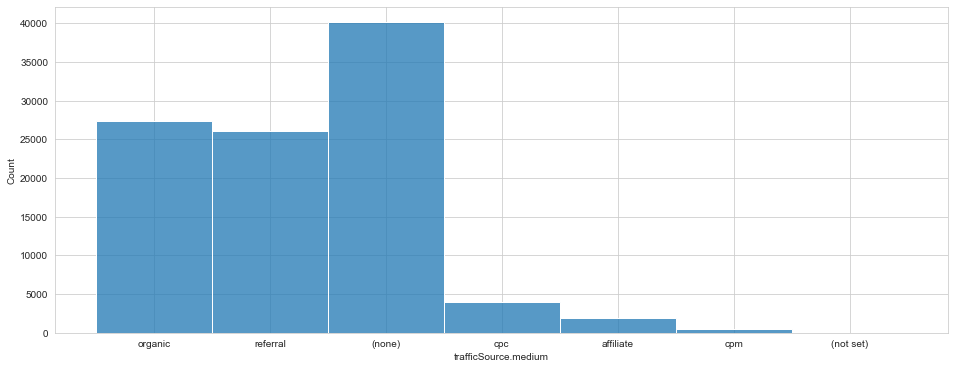

In [25]:
plt.figure(figsize=(16, 6))
sns.histplot(train_df['trafficSource.medium'])

<AxesSubplot:xlabel='trafficSource.medium', ylabel='totals.totalTransactionRevenue'>

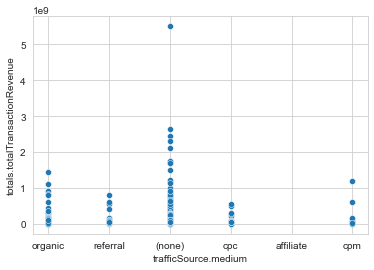

In [26]:
sns.scatterplot(x=train_df['trafficSource.medium'],y=train_df['totals.totalTransactionRevenue'])

In [27]:
categorical_list = ['trafficSource.adwordsClickInfo.adNetworkType','device.isMobile', \
'trafficSource.adwordsClickInfo.slot','device.deviceCategory','trafficSource.adwordsClickInfo.page', \
'geoNetwork.continent','trafficSource.medium','channelGrouping']

Once again, I will look at fill rate:

In [28]:
all_filled = train_df.isnull().sum().sort_values(ascending = True)
all_filled

channelGrouping                                     0
trafficSource.medium                                0
trafficSource.source                                0
trafficSource.campaign                              0
totals.hits                                         0
geoNetwork.city                                     0
geoNetwork.metro                                    0
geoNetwork.region                                   0
geoNetwork.country                                  0
geoNetwork.subContinent                             0
geoNetwork.networkDomain                            0
device.deviceCategory                               0
device.isMobile                                     0
device.operatingSystem                              0
device.browser                                      0
visitStartTime                                      0
date                                                0
visitNumber                                         0
fullVisitorId               

---------------
### Step 5. Exploring Potential Time Dependence

There are also many ways of analyzing the time variable, but for now I am just reducing the date variable to a 'day-of-week' with 7 categorical levels:

In [29]:
train_df['date'].head()

0    20171016
1    20171016
2    20171016
3    20171016
4    20171016
Name: date, dtype: int64

In [30]:
train_df['date'] = pd.to_datetime(train_df['date'])

In [31]:
train_df['date_day'] = train_df['date'].dt.day_name()

In [32]:
train_df['date_day'].head()

0    Thursday
1    Thursday
2    Thursday
3    Thursday
4    Thursday
Name: date_day, dtype: object

In [33]:
train_df['date_day'].value_counts()

Thursday    100000
Name: date_day, dtype: int64

it seems like the 'date' column may be unreliable, or I just haven't imported enough data.

There is a discussion about this on the Kaggle form which I may refer to in later analysis: 

https://www.kaggle.com/c/ga-customer-revenue-prediction/discussion/66815

---------

### Questions to be Answered: 

1. Are there any observations that need to be explored further?

2. Are there any trends that jump out?

3. What are some potential modeling approaches you want to consider?

4. Write-up a summary of your findings in a Markdown cell at the end, referencing 2+ figures and/or tables and discuss potential modeling approaches


### My Responses:

1. 

- Right now I am only looking at a subset of training data, I must use Dask or some other efficient processing method to get the full scope and re-run my EDA.

- There is an entire 'table' worth of data that I could not process due to already having too many columns. (the table is called `hits`, with metadata focused around content type, adsense variables, etc.). This table has 100+ variables, so I will not try to include it in an interpretable model.


2.

- The main trend is that most visitors do not convert into revenue-generation, and less than 1% do. Therefore, the model to-be-developed tackles a challenging problem of inbalanced data. Many real-world problems are focused on this kind of issue!

3.

- The most straightforward approach would be a kind of regression model for our numerical predictor. However with the inbalance of our data, combined with high # of signals / predictor columns, a neural network may perform much better.

- We have a datetime field, we can assess for trends over time, or we can aggregate and create new variables for certain blocks of time (weekly,monthly,daily aggregates). Time series autoregressive model might work, but may not be ideal with low fill rate of target variable.

4. Summary

- There are many predictor variables available, but most of them are uninformative. A major part of this EDA was to determine which fields are likely to give us value during the modelling process.

- The analysis of the response variable showed that the data is mostly filled with non-revenue generating customers. Therefore, it becomes even more important that we can identify the best signals during this pre-modelling step. While our response variable is definitely skewed, a log transformation (shown at the end of Step 3: Exploring the Target Variable) will help us make more reasonable predictions (instead of just predicting 0 revenue all the time)

- Much of our predictive power will likely come from demographic and device data (see scatterplots in Step 3: Exploring the Predictor Variables). Their fill rates are great, and there seems to be some trends against our Revenue variable. 